# 5.2 Implementation of Multilayer Perceptrons

MNIST contains 10 classes, and that each image consists of a  28×28=784 grid of grayscale pixel values. we will implement an MLP with one hidden layer and 256 hidden units.

In [1]:
import Flux,Plots

### Model
We’ll define our model to consist of two fully connected layers, with a softmax at the end for easing inference:

In [2]:
using Flux
model = Chain(
  Dense(28*28,40, relu),
  Dense(40, 10),
  softmax)


Chain(
  Dense(784 => 40, relu),               # 31_400 parameters
  Dense(40 => 10),                      # 410 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 31_810 parameters, 124.508 KiB.

In [12]:
softmax(range(-14,14,length=15))

15-element Vector{Float64}:
 5.978637810056745e-13
 4.417649017369718e-12
 3.264225641473071e-11
 2.411954638441241e-10
 1.7822068131518322e-9
 1.3168826122275303e-8
 9.730519497455558e-8
 7.18993544384376e-7
 5.312683634225139e-6
 3.925571740916031e-5
 0.0002900626981400541
 0.0021432895487640473
 0.015836886712069304
 0.11701964434788946
 0.8646647167634682

### Data loading

In [7]:
using MLDatasets

# load training set
train_x, train_y = MNIST.traindata();

# load test set
test_x,  test_y  = MNIST.testdata();

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Peter.Katalin\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Peter.Katalin\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


### Preprocessing
- convert train data from grayscale to float <br>
- use a function from Flux to one-hot encode our labels <br>


In [14]:
x_train = Float32.(train_x)
y_train = Flux.onehotbatch(train_y, 0:9);

x_test = Float32.(test_x)
y_test = Flux.onehotbatch(test_y, 0:9);

Excessive output truncated after 1200024 bytes.

In [15]:
y_test

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

### Training

We will use crossentropy, but logitcrossentropy works too. Flux documentation says: <br>
"This is mathematically equivalent to crossentropy(softmax(ŷ), y), but is more numerically stable than using functions crossentropy and softmax separately."

In [16]:
loss(X, y) = Flux.crossentropy(model(X), y)

#adaptative moment estimation  (combines loss function and parameters)
opt = Flux.ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

### Training

In [17]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_test()
    test_data = [(Flux.flatten(x_test), test_y)]
    accuracy = 0
    err=0;
    nr_of_errors=0
    for i in 1:length(test_y)
        if findmax(model(test_data[1][1][:, i]))[2] - 1  == test_y[i]
            accuracy = accuracy + 1
        else
            nr_of_errors=nr_of_errors+1
            A=abs.(model(test_data[1][1][:, i]) .- y_test[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end
    
    m = accuracy / length(test_y)
    n = err/ length(test_y)
    s = nr_of_errors 
    println("The val_accuracy is: ",m)
    println("Mean absolute error (TEST): ",n)
    println("Number of errors: ",s)
    return m,n,s
end

calculate_accuracy_test (generic function with 1 method)

In [18]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_train()
    train_data = [(Flux.flatten(x_train), train_y)]
    err=0;
    for i in 1:length(train_y)
        if findmax(model(train_data[1][1][:, i]))[2] - 1  != train_y[i]
            A=abs.(model(train_data[1][1][:, i]) .- y_train[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end    
    n = err/ length(train_y)
    println("Mean absolute error (TRAIN): ",n)
    return n
end

calculate_accuracy_train (generic function with 1 method)

In [19]:
using Flux

parameters = Flux.params(model)
# flatten() function converts array 28x28x60000 into 784x60000 
train_data = [(Flux.flatten(x_train), Flux.flatten(y_train))]

val_acc=zeros(0)
mean_err_test=zeros(0)
nr_err=zeros(0)
mean_err_train=zeros(0)
nr_of_epoch=8

for i in 1:nr_of_epoch
    println("epoch ",i)
    Flux.train!(loss, parameters, train_data, opt)
    
    n = calculate_accuracy_train()
    append!(mean_err_train,n)
    m, n, s = calculate_accuracy_test()
    append!( val_acc, m )
    append!( mean_err_test, n )
    append!( nr_err, s )
    
end



epoch 1
Mean absolute error (TRAIN): 1.4649382
The val_accuracy is: 0.1911
Mean absolute error (TEST): 1.4681834
Number of errors: 8089
epoch 2
Mean absolute error (TRAIN): 1.3901122
The val_accuracy is: 0.2296
Mean absolute error (TEST): 1.3886414
Number of errors: 7704
epoch 3
Mean absolute error (TRAIN): 1.2870597
The val_accuracy is: 0.2786
Mean absolute error (TEST): 1.2921631
Number of errors: 7214
epoch 4
Mean absolute error (TRAIN): 1.1683668
The val_accuracy is: 0.3415
Mean absolute error (TEST): 1.1731677
Number of errors: 6585
epoch 5
Mean absolute error (TRAIN): 1.048562
The val_accuracy is: 0.4055
Mean absolute error (TEST): 1.0540203
Number of errors: 5945
epoch 6
Mean absolute error (TRAIN): 0.9408792
The val_accuracy is: 0.4693
Mean absolute error (TEST): 0.9374549
Number of errors: 5307
epoch 7
Mean absolute error (TRAIN): 0.85425234
The val_accuracy is: 0.5206
Mean absolute error (TEST): 0.8447753
Number of errors: 4794
epoch 8
Mean absolute error (TRAIN): 0.7896952
T

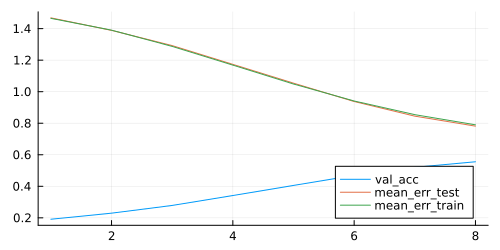

In [20]:
x = range(1, nr_of_epoch, step=1)

p= Plots.plot(x,val_acc,label="val_acc",legend=:bottomright, size=(500, 250))
p= Plots.plot!(p,x,mean_err_test,label="mean_err_test")
p= Plots.plot!(p,x,mean_err_train,label="mean_err_train")